# Distribution evolution

Now that we can make a distribution and calculate coagulation rates, let's move that forward in time.

In [14]:
try:
    import particula, matplotlib
except ImportError:
    print("Setting up computational environment...")
    %pip install -U particula -qqq
    %pip install matplotlib -qqq


from particula import particle, rates
import numpy as np
from matplotlib import pyplot as plt
from particula.util.coagulation_rate import CoagulationRate
from particula.util.dimensionless_coagulation import full_coag
from particula.util.input_handling import in_time

We can do this in a simple way by using a for loop to march through the time steps.

In [15]:
# Time steps

simple_dic_kwargs = {
    "mode": 200e-9, # 200 nm median
    "nbins": 500, # 1000 bins
    "nparticles": 1e6, # 1e4 #
    "volume": 1e-6, # per 1e-6 m^3 (or 1 cc)
    "gsigma": 1.5, # relatively narrow
}
particle_dist2 = particle.Particle(**simple_dic_kwargs) # pass the kwargs using ** prefix

#inital distribution
p_distribution_0 = particle_dist2.particle_distribution()
p_radius = particle_dist2.particle_radius
coag_kernel = full_coag(radius=p_radius)

p_distribution_i = p_distribution_0

time_interval = in_time(10)
time_array = np.arange(0, 1000, time_interval.m)

distribution_time = np.zeros([len(time_array), len(p_distribution_0)])

for i, dpa in enumerate(time_array):

    if i>0:
        # calculate coagulations
        coag_gain_i = CoagulationRate(p_distribution_i, p_radius, coag_kernel).coag_gain()
        coag_loss_i = CoagulationRate(p_distribution_i, p_radius, coag_kernel).coag_loss()

        net_change = (coag_gain_i-coag_loss_i)*time_interval
        p_distribution_i = p_distribution_i+net_change

    distribution_time[i,:] = p_distribution_i.m

## For loop Graph

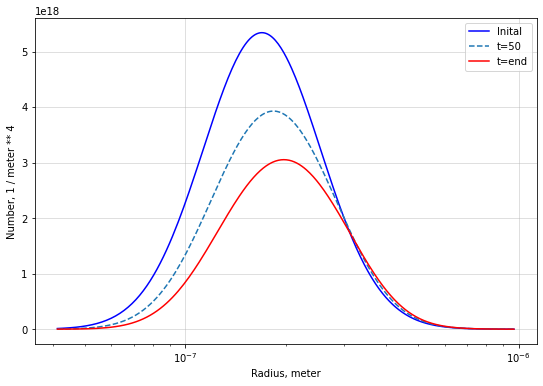

In [22]:
fig, ax = plt.subplots(1, 1, figsize=[9, 6])

radius = p_radius.m
ax.semilogx(radius, p_distribution_0.m, '-b', label='Inital')
ax.semilogx(radius, distribution_time[49,:], '--', label='t=50')
ax.semilogx(radius, distribution_time[-1,:], '-r', label='t=end')

ax.legend()
ax.set_ylabel(f"Number, {particle_dist2.particle_distribution().u}")
ax.set_xlabel(f"Radius, {particle_dist2.particle_radius.u}")
ax.grid(True, alpha=0.5)

## ODE solver
Instead of prescribing the time steps, which can make the problem solution unstable, let's let the code handle that with an ODE solver.

Lets import that solver class

In [17]:
from particula.util.simple_solver import SimpleSolver

Then let us run the same dynamic problem again

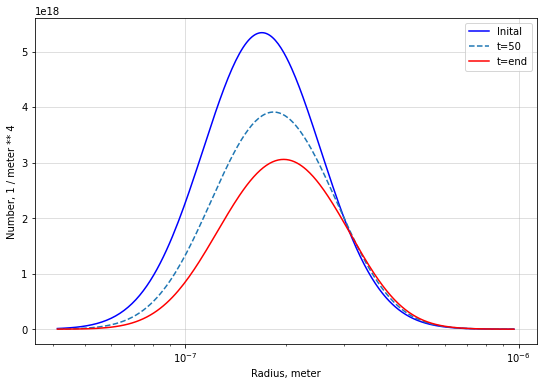

In [18]:
simple_dic_kwargs = {
    "mode": 200e-9, # 200 nm median
    "nbins": 500, # 1000 bins
    "nparticles": 1e6, # 1e4 #
    "volume": 1e-6, # per 1e-6 m^3 (or 1 cc)
    "gsigma": 1.5, # relatively narrow
}
particle_dist2 = particle.Particle(**simple_dic_kwargs) # pass the kwargs using ** prefix

#inital distribution coag kernel
coag_kernel = full_coag(radius=particle_dist2.particle_radius)
time_array = np.arange(0, 1000, 10)

#setup the inital state of the distribution
problem = {
    "distribution": particle_dist2.particle_distribution(),
    "radius": particle_dist2.particle_radius,
    "kernel": coag_kernel,
    "tspan": time_array
}

#call the solver
solution = SimpleSolver(**problem).solution()

#plot
fig, ax = plt.subplots(1, 1, figsize=[9, 6])

radius = p_radius.m
ax.semilogx(radius, particle_dist2.particle_distribution().m, '-b', label='Inital')
ax.semilogx(radius, solution.m[49,:], '--', label='t=50')
ax.semilogx(radius, solution.m[-1,:], '-r', label='t=end')

ax.legend()
ax.set_ylabel(f"Number, {particle_dist2.particle_distribution().u}")
ax.set_xlabel(f"Radius, {particle_dist2.particle_radius.u}")
ax.grid(True, alpha=0.5)


## summary on stepping
As we walked through, using the ODE solver is quite a nice way to get to the answer, without figuring out what time-step you might need.
